In [7]:
import numpy as np
import cv2
import sys
import glob
from matplotlib import pyplot as plt

In [8]:
def get_HOG_descriptors(img_gray, kps, win_size=(64, 64)):
    result = []
    for i, kp in enumerate(kps):
        # Read (x,y) coordinate from the current keypoint
        # https://docs.opencv.org/3.2.0/d2/d29/classcv_1_1KeyPoint.html
        x, y = kp.pt[0], kp.pt[1]

        # Create a win_size crop window for this keypoint
        left = int(x - (win_size[0]//2))
        right = int(x + (win_size[0]//2))
        if left < 0:
            left = 0
            right = left + win_size[0] + 1
        if right > img_gray.shape[1]-1:
            right = img_gray.shape[1]
            left = right - win_size[0] - 1
        top = int(y - (win_size[1]//2))
        bottom = int(y + (win_size[1]//2))
        if top < 0:
            top = 0
            bottom = top + win_size[1] + 1
        if bottom > img_gray.shape[0]-1:
            bottom = img_gray.shape[0]
            top = bottom - win_size[1] - 1

        # Crop the image with the window
        img_crop = img_gray[top:bottom, left:right]

        # Compute a HOG descriptor
        # Be careful, dimension of img_crop must match with winSize (as specified at hog initiation)
        desc = hog.compute(img_crop)

        # Add the descriptor to the resultant list
        result.append(desc)

    return np.asarray(result, np.float32)


In [9]:
# Initiate FAST detector
fast = cv2.FastFeatureDetector_create()

# Initiate HOG descriptor with default parameters
# size of the image sent to compute HOG
winSize = (16, 16)
# block size for block normalization
blockSize = tuple([i//2 for i in winSize])
blockStride = tuple([i//2 for i in blockSize])
# cell size (one cell for one 9-bin HOG)
cellSize = blockSize
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64
hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins, derivAperture, winSigma,
                        histogramNormType, L2HysThreshold, gammaCorrection, nlevels)

# Initiate FLANN matching
# Since HOG descriptor is similar to SIFT/SURF descriptor, use the same matching technique
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)


In [10]:
# training data
dataset_path = "dataset/image/design1/*.jpg"
files = glob.glob(dataset_path) 

In [11]:
# create template
template_names = []
template_descs = []
template_bgrs = []
template_kpss = []
for item in files:
    name = item.split('/')[-1].split('.')[0]
    template_names.append(name)
    template_bgr = cv2.imread(item)
    template_gray = cv2.cvtColor(template_bgr, cv2.COLOR_BGR2GRAY)
    template_kps = fast.detect(template_gray, None)
    template_bgrs.append(template_bgr)
    template_kpss.append(template_kps)
    template_descs.append(get_HOG_descriptors(template_gray, template_kps, winSize))

In [12]:
# test data
test_path = "dataset/image/real/*.png"
# test_path = "dataset/image/design1/*.jpg"
test_files = glob.glob(test_path) 

In [13]:
def detect_sign(dir):
    cam_bgr = cv2.imread(dir)
    cam_gray = cv2.cvtColor(cam_bgr, cv2.COLOR_BGR2GRAY)

    # Find FAST keypoints with non-maximum supression
    cam_kps = fast.detect(cam_gray, None)

    # Find HOG descriptors
    cam_descs = get_HOG_descriptors(cam_gray, cam_kps, winSize)

    max_counter = 0
    max_matcher = None
    max_matchesMask = None
    max_template = None
    # Find two best matches
    for j in range(len(template_descs)):
        matches = flann.knnMatch(template_descs[j],   # query set of descriptors
                                cam_descs,       # train set of descriptors
                                k=2)             # only find two best matches for each query descriptor
        # Ratio test for eliminating poor matches
        matchesMask = [[0, 0] for i in range(len(matches))]
        counter = 0
        for i, mn in enumerate(matches):
            if (len(mn) == 2):                # prevent the case when only one match is found
                m = mn[0]
                n = mn[1]        # 'm' is the best match, 'n' is the second-best match
                if m.distance < 0.7 * n.distance:
                    matchesMask[i] = [1, 0]
                    counter += 1
        
        if counter >= max_counter:
            max_counter = counter
            max_matcher = matches
            max_matchesMask = matchesMask
            max_template = j
    
    print('The number of good matches =', max_counter)
    # Draw matching result
    # cv2.drawMatchesKnn expects list of lists as matches.
    result = cv2.drawMatchesKnn(template_bgrs[max_template], template_kpss[max_template],
                                cam_bgr, cam_kps,
                                max_matcher,
                                None,                          # output image
                                # use random colors to draw the matching line
                                matchColor=(-1, -1, -1),
                                # use random colors to draw each keypoint
                                singlePointColor=(-1, -1, -1),
                                matchesMask=max_matchesMask,
                                flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    titles = [ 'cam_bgr', 'result']
    images = [ cam_bgr, result]
    fig = plt.figure(figsize=(15,8))
    fig.canvas.set_window_title('FAST+HOG: Feature Matching')
    for i in range(len(titles)):
        plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
        plt.title(titles[i])
        plt.xticks([]),plt.yticks([])
        # cv2.imshow('FAST+HOG: Feature Matching', result)

In [71]:
# noise removal
def remove_noise(image, k):
    return cv2.GaussianBlur(image,(k,k),0)
    # return cv2.medianBlur(image,k)


#thresholding_otsu
def thresholding_otsu(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#thresholding
def thresholding(image):
    # return cv2.threshold(image,0, 100, cv2.THRESH_BINARY)[1]
    return cv2.adaptiveThreshold(image,                        # 8-bit 1-channel
                                255,                        # max value
                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                cv2.THRESH_BINARY,
                                ksize,                      # kernel size
                                2 )                         # C constant

#dilation
def dilate(image, cnt_dilate):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = cnt_dilate)
    
#erosion
def erode(image, cnt_erode):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = cnt_erode)

#closing
def closing(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

#opening
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 255)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)


In [72]:
ksize = 7

In [87]:
def mark_hsv(color, src_bgr):
    th1 = 25
    th2 = 30
    # Convert to HSV and split each channel
    src_hsv = cv2.cvtColor( src_bgr, cv2.COLOR_BGR2HSV )
    src_h = src_hsv[...,0]
    src_s = src_hsv[...,1]
    src_v = src_hsv[...,2]

    # Choose only pixels whose HUE values are in our preferred range
    mask_h = ( src_h >= th1 ) & ( src_h <= th2 )
    print( mask_h.shape , mask_h.dtype )

    # Choose only pixels whose SAT values exceed our minimum requirement
    min_sat = 0.2
    mask_s = ( src_s >= min_sat*255 )
    print( mask_s.shape , mask_s.dtype )

    # Combine two masks into one final mask
    # mask_hs = mask_h & mask_s
    mask_hs = ( src_h >= th1 ) & ( src_h <= th2 ) & ( src_s >= 0.2 * 255 )
    print( mask_hs.shape , mask_hs.dtype )

    # Change from 1-channel mask_hs to 3-channel mask_hs_3ch
    h,w = mask_hs.shape[:2]
    mask_hs_3ch = np.zeros( (h,w,3), dtype=mask_hs.dtype )
    mask_hs_3ch[ ..., 0 ] = mask_hs
    mask_hs_3ch[ ..., 1 ] = mask_hs
    mask_hs_3ch[ ..., 2 ] = mask_hs
    print( mask_hs_3ch.shape , mask_hs_3ch.dtype  )

    # Change from True-False image to 0-255 image
    mask_hs_3ch = ( mask_hs_3ch.astype(np.uint8) ) * 255
    print( mask_hs_3ch.shape , mask_hs_3ch.dtype  )

    # Segment the input image with our final mask (=binary image, np.uint8)
    src_segment = ( src_bgr & mask_hs_3ch )
    print( src_segment.shape , src_segment.dtype )

    # return src_segment
    return mask_hs_3ch

In [187]:
def get_mark_gray(dir):
    img = cv2.imread(dir)
    print( 'img',img.shape )
    # resize
    h, w, _= img.shape
    if h > w:
        img = cv2.resize(img,(150, round(150 * h / w) ))        
    else:
        img = cv2.resize(img,(round(150 * w / h),150))
    print( 'img-resize',img.shape )
    # rgb for present
    img_org = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    # gray
    img_gray = cv2.cvtColor(img.copy(),cv2.COLOR_BGR2GRAY)
    img_gray = remove_noise(img_gray, 3)
    
    img_candy = canny(img_gray)

    # Find all contours
    contours, hierarchy = cv2.findContours(img_candy,
                                          cv2.RETR_LIST,
                                          cv2.CHAIN_APPROX_NONE)
    # Draw all contours (on black images) using random color
    # for c in contours:
        # color = ( randint(0,255), randint(0,255), randint(0,255) )
    # img_object = cv2.drawContours ( img_org.copy(), contours, -1, (0,255,0), thickness=2 )
    # print(contours)
    contours_mark = []
    boxs = []
    max_area = 0
    max_length = 0
    img_box = img.copy()
    for c in contours:
        if cv2.contourArea(c) > max_area:
            max_area = cv2.contourArea(c)
        if cv2.arcLength(c,False) > max_length:
            max_length = cv2.arcLength(c,False)
        if cv2.contourArea(c) > 900 or cv2.arcLength(c,False) > 500:
            contours_mark.append(c)
            x,y,w,h = cv2.boundingRect(c)
            cv2.rectangle(img_box,(x,y),(x+w,y+h),(0,255,0),2)
        # print(cv2.contourArea(c),cv2.arcLength(c,False))
    print('max', max_area, max_length)
    #     if cv2.contourArea(c) >= 10:
    #         contours_mark.append(c)
    # print("*"*25)
    # print(contours_mark)
    # for c in contours_mark:
    #     print(cv2.contourArea(c))
    # mark_object = cv2.drawContours( img_org.copy(),contours_mark,0, 
    #               (0,255,0), 
    #               thickness=-1)
    
    
    mark_object = cv2.drawContours( img_org.copy(),contours_mark,-1, 
                  (0,255,0), 
                  thickness=2)
                  
    # img_object = mark_object
    # title
    titles = [ 'img_org',  'img_gray','img_candy','mark_object','img_box']
    images = [ img_org,  img_gray ,img_candy,mark_object,img_box]

    # Show all resultant images using pyplot
    fig = plt.figure(figsize=(15,8))
    fig.canvas.set_window_title('OpenCV')
    for i in range(len(titles)):
        plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
        plt.title(titles[i])
        plt.xticks([]),plt.yticks([])

img (167, 117, 3)
img-resize (214, 150, 3)
max 1117.0 556.9453008174896
img (532, 186, 3)
img-resize (429, 150, 3)
max 5764.0 2132.545367836952
img (685, 257, 3)
img-resize (400, 150, 3)
max 9946.0 641.6101716756821
img (258, 132, 3)
img-resize (293, 150, 3)
max 7525.0 564.3137083053589
img (310, 102, 3)
img-resize (456, 150, 3)
max 332.0 550.9898953437805
img (226, 101, 3)
img-resize (336, 150, 3)
max 84.5 352.32590091228485


/var/folders/81/801rlldj66b9mqn09r7s37jr0000gn/T/ipykernel_14488/4223953881.py:66: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title('OpenCV')


img (86, 99, 3)
img-resize (150, 173, 3)
max 489.5 559.192993760109
img (125, 127, 3)
img-resize (150, 152, 3)
max 12779.5 416.74725472927094
img (333, 127, 3)
img-resize (393, 150, 3)
max 12364.0 636.6883796453476
img (182, 624, 3)
img-resize (150, 514, 3)
max 2292.0 4868.559983491898


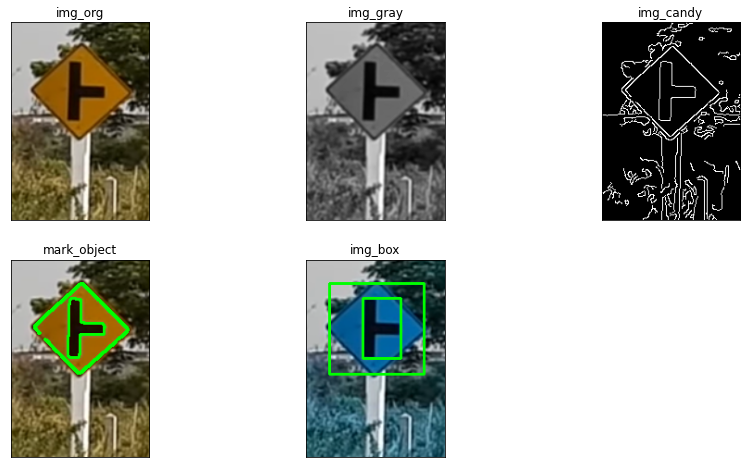

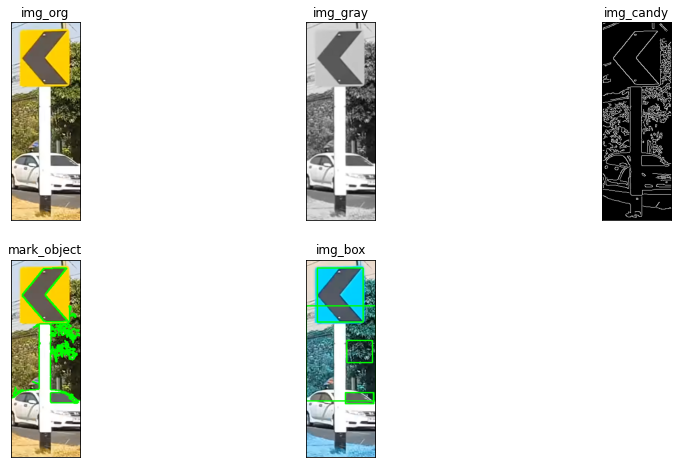

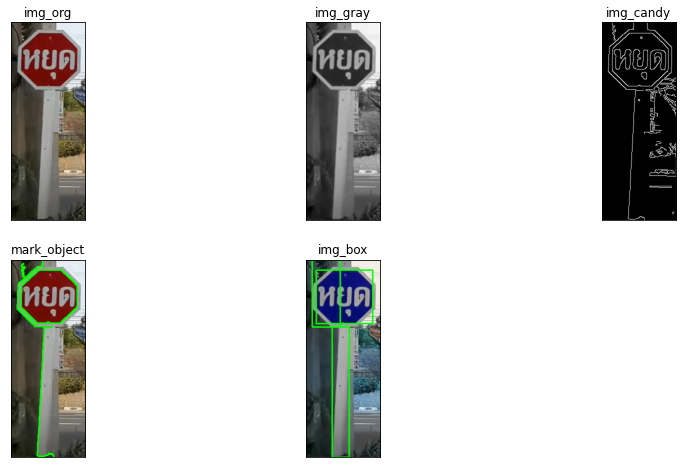

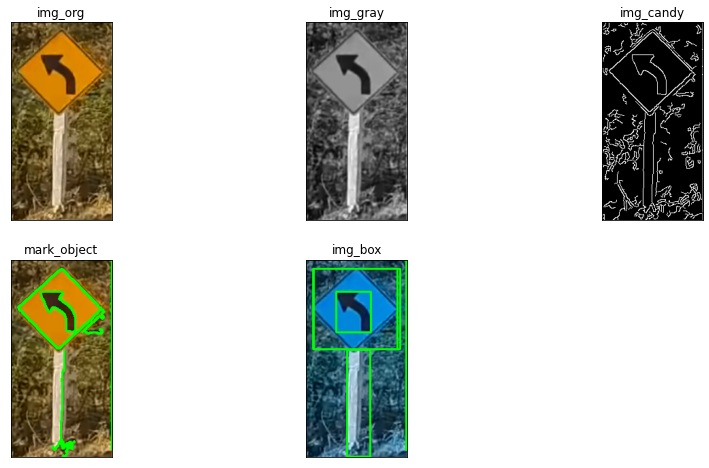

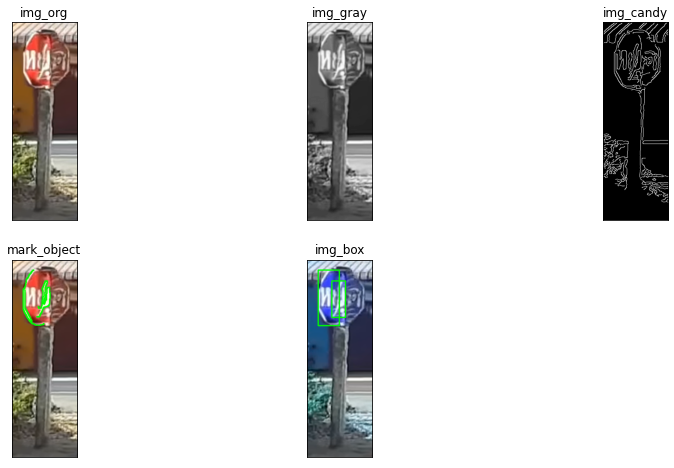

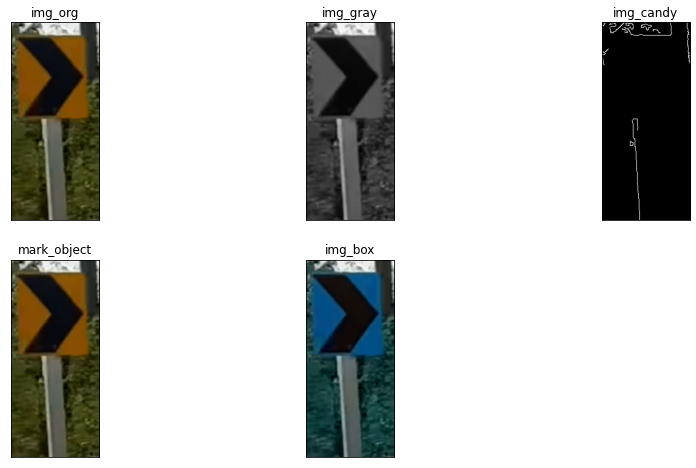

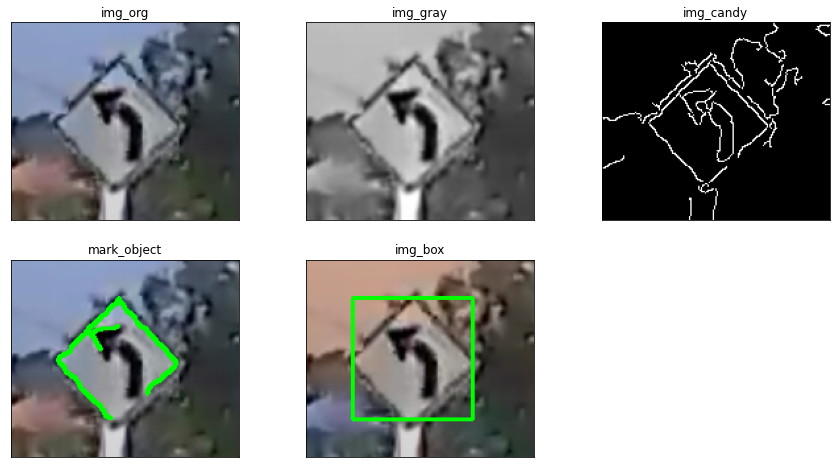

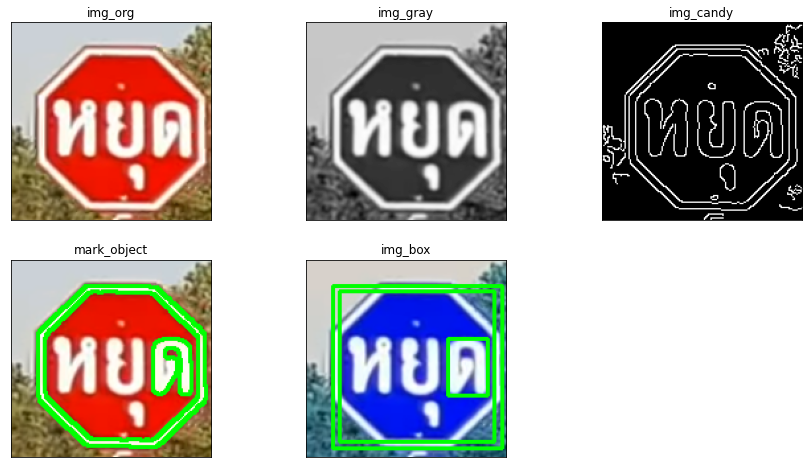

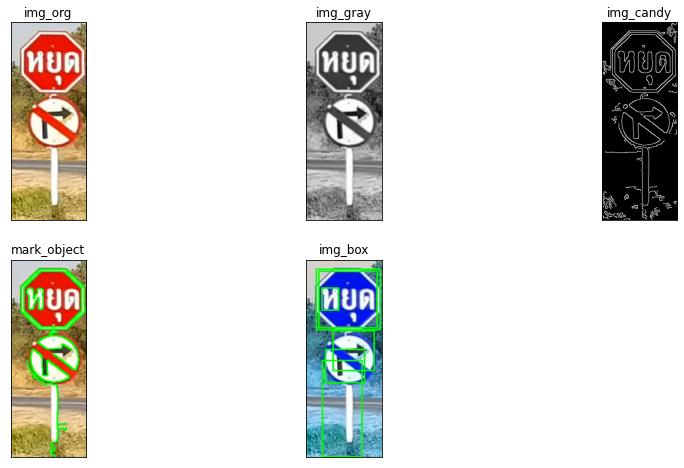

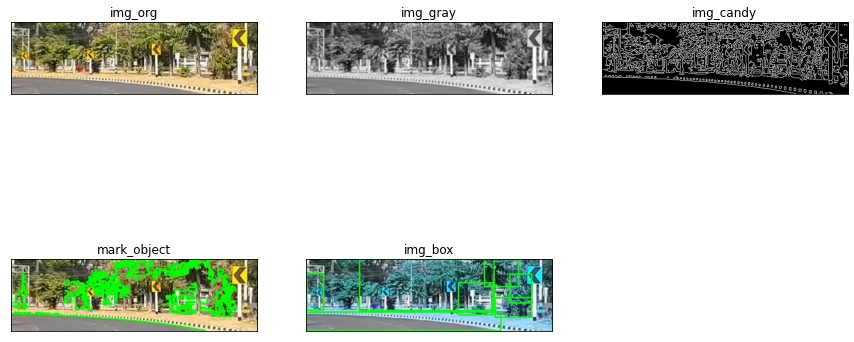

In [188]:
for item in test_files[:10]:
    try:
        get_mark_gray(item)
    except:
        print(item)

In [ ]:
def get_mark(dir):
    img = cv2.imread(dir)
    print( 'img',img.shape )
    img_gray_org = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # resize
    img = cv2.resize(img,(100,200))

    img_bright = cv2.convertScaleAbs(img, alpha=2.2, beta=50)
    img_bright = remove_noise(img_bright, 3)
    
    # new_image = cv2.cvtColor(new_image,cv2.COLOR_BGR2RGB)

    img_org = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    # get yellow
    img_yellow = mark_hsv(None, img_bright)
    img_gray = img_yellow
    # smooth
    img_gray = remove_noise(img_gray, 5)
    # img_gray = dilate(img_gray, 1)
    # img_gray = closing(img_gray)
    img_gray = erode(img_gray, 1)
    img_gray = dilate(img_gray, 1)
    # img_gray = closing(img_gray)

    # get white object
    # global_thres = 180
    # img_white = cv2.threshold( img_noise, global_thres, 255, cv2.THRESH_BINARY )[1]
    # img_white = remove_noise(img_white, 13)
    # img_white = dilate(img_white, 1)
    # img_white = closing(img_white)
    # img_white = erode(img_white, 2)
    # img_white = closing(img_white)
    
    # img_thresh = thresholding(img_noise)

    img_candy = canny(img_gray)

    # Find all contours
    contours, hierarchy = cv2.findContours(img_candy,
                                          cv2.RETR_LIST,
                                          cv2.CHAIN_APPROX_SIMPLE)
    # # Find all contours - polygon
    # eps_greyth = 20
    # ctimg_greyth_copy = np.zeros_like ( img )
    # contours_greyth_approx = []
    # for c in contours:
    #     c_approx = cv2.approxPolyDP ( c, eps_greyth, True )
    #     cv2.drawContours( ctimg_greyth_copy, [c_approx], -1, (0,255,0), 2 )  
    #     contours_greyth_approx.append( c_approx )
    # # Draw all contours as green outlines overlaid on an original image
    # img_object = img_gray.copy()
    # # mark_object = np.zeros_like(img_object)
    # # Draw all contours (on black images) using random color
    # # for c in contours:
    #     # color = ( randint(0,255), randint(0,255), randint(0,255) )
    # img_object = cv2.drawContours ( img_org.copy(), contours, -1, (0,255,0), thickness=2 )
        # mark_object = cv2.drawContours(
        #     mark_object,[ max(contours, key=cv2.contourArea) ],0, 
        #           (255,255,255), 
        #           thickness=-1)
    # img_object = mark_object
    # img_object = img_object & mark_object

    # obj_thresh = cv2.threshold(img_object, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    
    # obj_thresh = thresholding(img_object)
    # obj_thresh = ~ obj_thresh
    # obj_thresh = remove_noise(obj_thresh, 5)
    # obj_edge = canny(obj_thresh)
   
    # title
    titles = [ 'img_org', 'img_bright', 'img_yellow','img_candy','img_gray_org']
    images = [ img_org, img_bright,  img_yellow ,img_candy,img_gray_org]

    # Show all resultant images using pyplot
    fig = plt.figure(figsize=(15,8))
    fig.canvas.set_window_title('OpenCV')
    for i in range(len(titles)):
        plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
        plt.title(titles[i])
        plt.xticks([]),plt.yticks([])

img (167, 117, 3)
(200, 100) bool
(200, 100) bool
(200, 100) bool
(200, 100, 3) bool
(200, 100, 3) uint8
(200, 100, 3) uint8
img (532, 186, 3)
(200, 100) bool
(200, 100) bool
(200, 100) bool
(200, 100, 3) bool
(200, 100, 3) uint8
(200, 100, 3) uint8
img (685, 257, 3)
(200, 100) bool
(200, 100) bool
(200, 100) bool
(200, 100, 3) bool
(200, 100, 3) uint8
(200, 100, 3) uint8
img (258, 132, 3)
(200, 100) bool
(200, 100) bool
(200, 100) bool
(200, 100, 3) bool
(200, 100, 3) uint8
(200, 100, 3) uint8
img (310, 102, 3)
(200, 100) bool
(200, 100) bool
(200, 100) bool
(200, 100, 3) bool
(200, 100, 3) uint8
(200, 100, 3) uint8
img (226, 101, 3)
(200, 100) bool
(200, 100) bool
(200, 100) bool
(200, 100, 3) bool
(200, 100, 3) uint8
(200, 100, 3) uint8


/var/folders/81/801rlldj66b9mqn09r7s37jr0000gn/T/ipykernel_14488/2238119917.py:78: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title('OpenCV')


img (86, 99, 3)
(200, 100) bool
(200, 100) bool
(200, 100) bool
(200, 100, 3) bool
(200, 100, 3) uint8
(200, 100, 3) uint8
img (125, 127, 3)
(200, 100) bool
(200, 100) bool
(200, 100) bool
(200, 100, 3) bool
(200, 100, 3) uint8
(200, 100, 3) uint8
img (333, 127, 3)
(200, 100) bool
(200, 100) bool
(200, 100) bool
(200, 100, 3) bool
(200, 100, 3) uint8
(200, 100, 3) uint8
img (182, 624, 3)
(200, 100) bool
(200, 100) bool
(200, 100) bool
(200, 100, 3) bool
(200, 100, 3) uint8
(200, 100, 3) uint8
dataset/image/real/curve_right_1.png
img (166, 125, 3)
(200, 100) bool
(200, 100) bool
(200, 100) bool
(200, 100, 3) bool
(200, 100, 3) uint8
(200, 100, 3) uint8
img (139, 141, 3)
(200, 100) bool
(200, 100) bool
(200, 100) bool
(200, 100, 3) bool
(200, 100, 3) uint8
(200, 100, 3) uint8
img (333, 127, 3)
(200, 100) bool
(200, 100) bool
(200, 100) bool
(200, 100, 3) bool
(200, 100, 3) uint8
(200, 100, 3) uint8
img (243, 106, 3)
(200, 100) bool
(200, 100) bool
(200, 100) bool
(200, 100, 3) bool
(200,

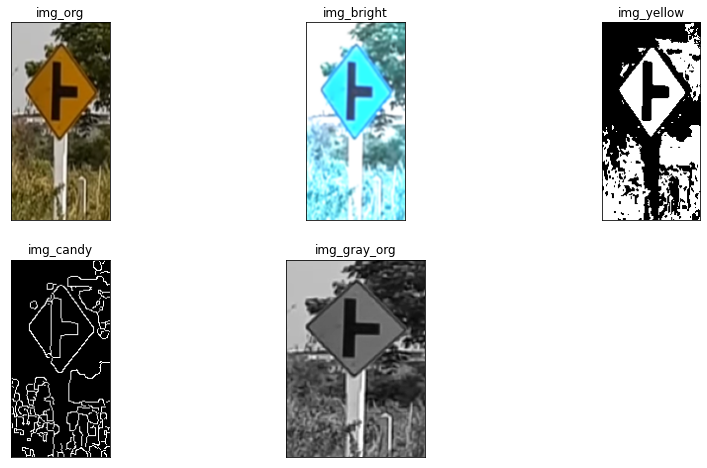

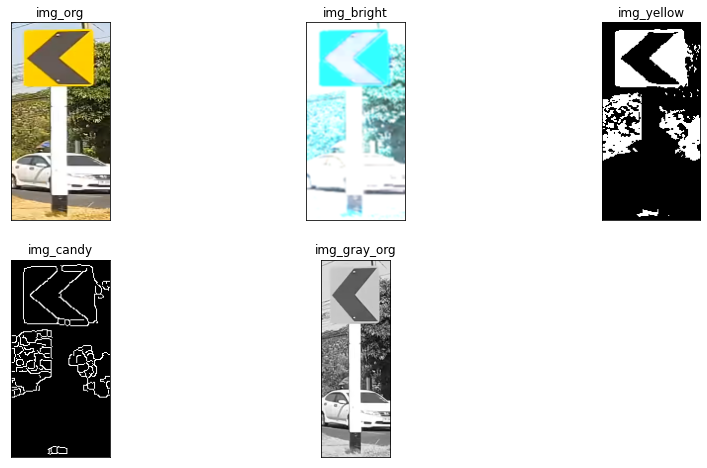

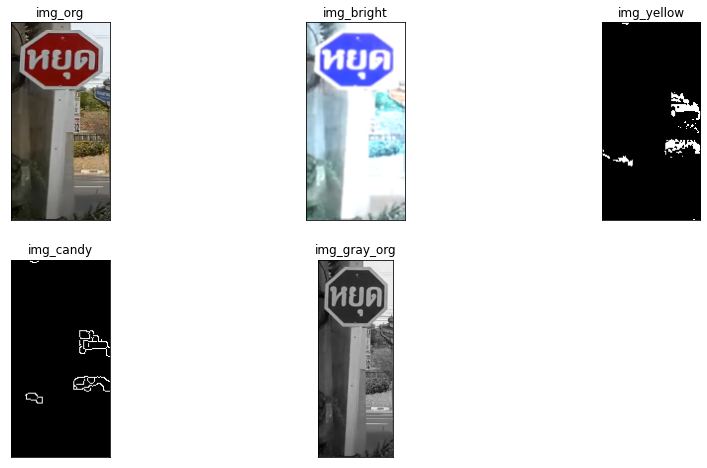

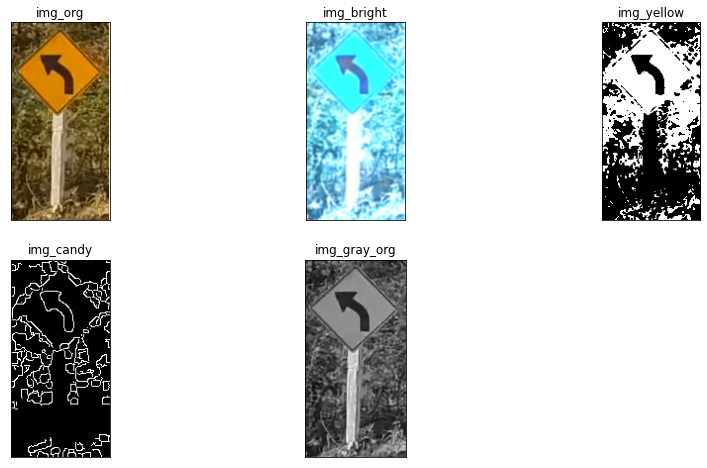

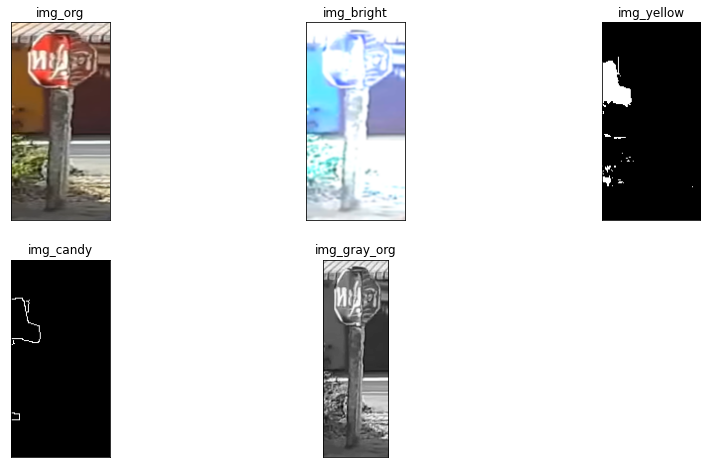

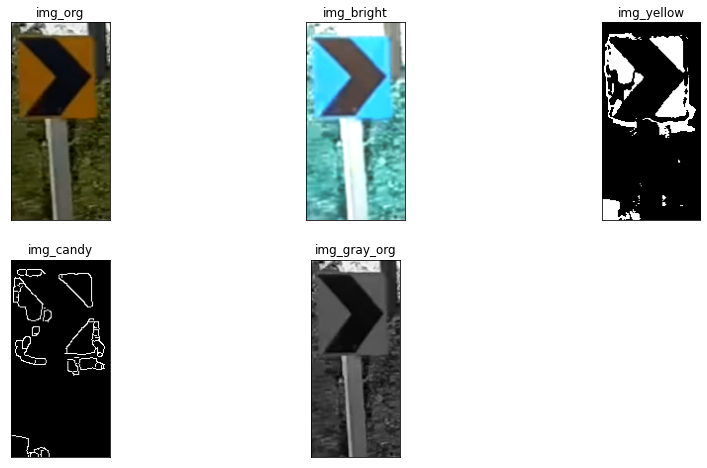

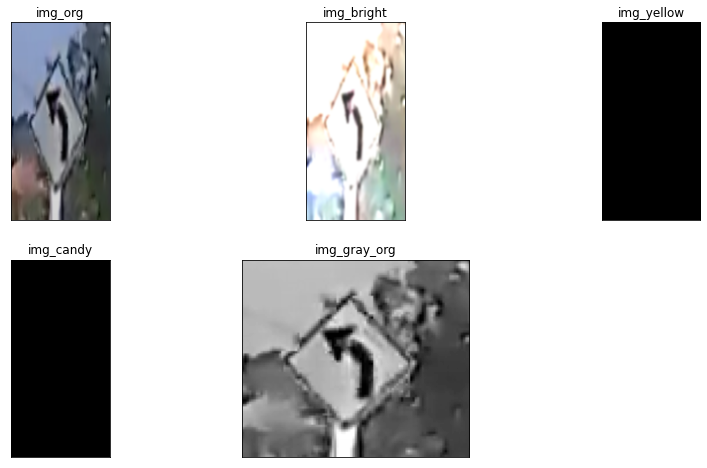

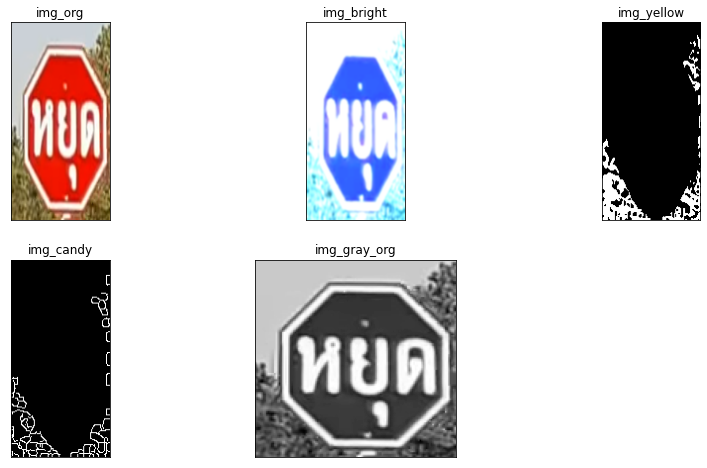

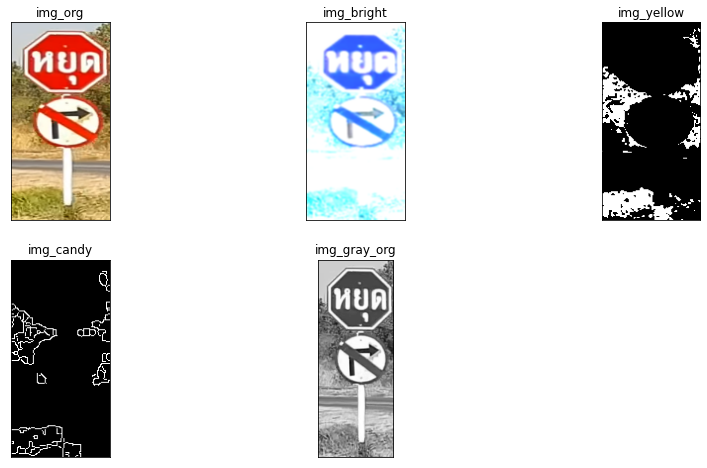

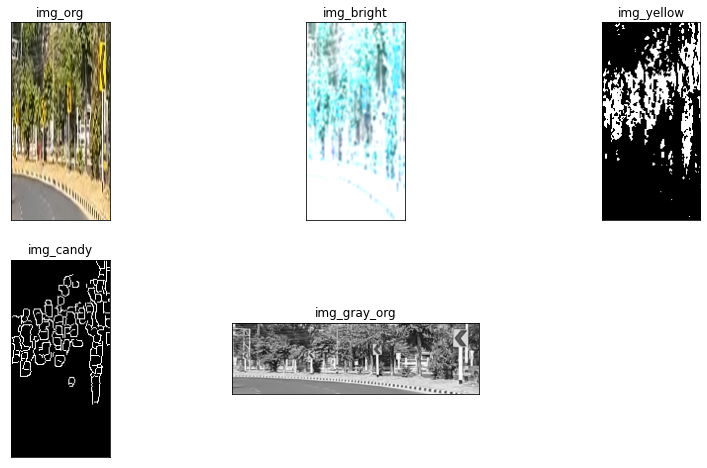

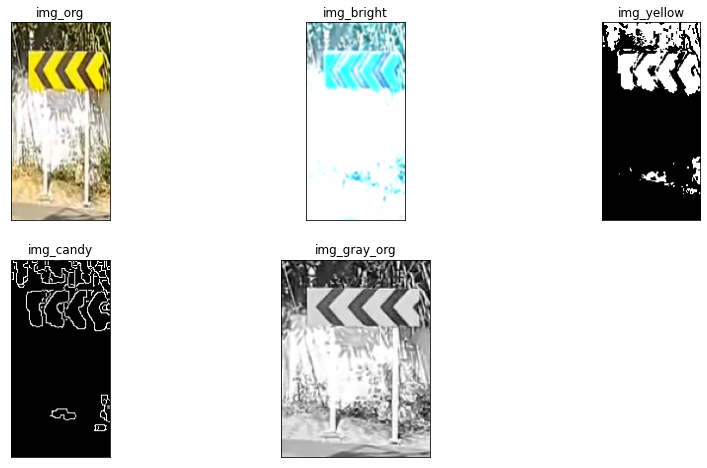

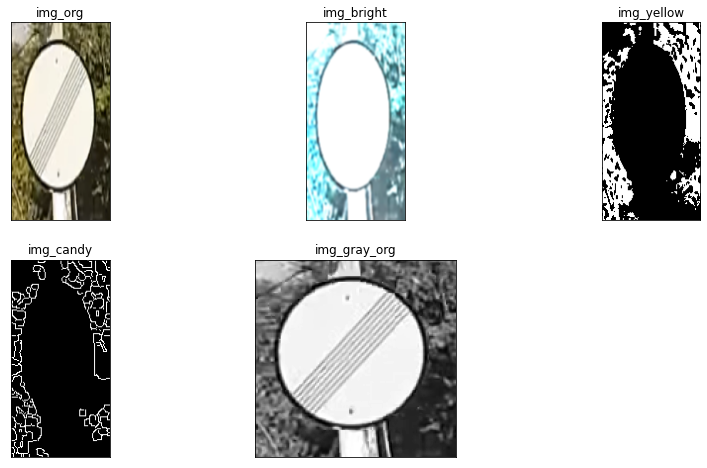

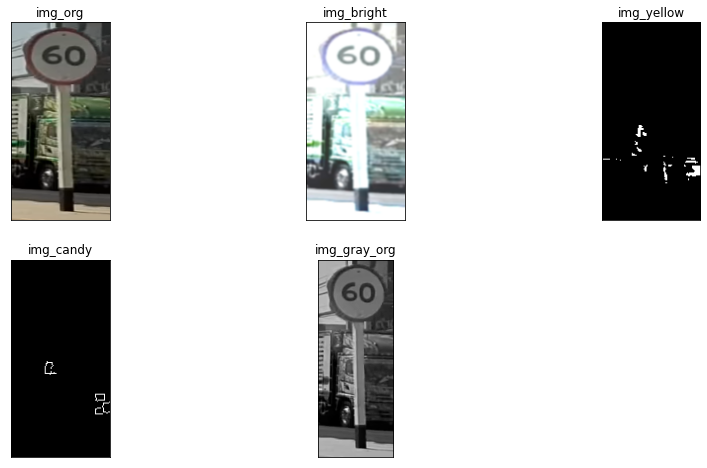

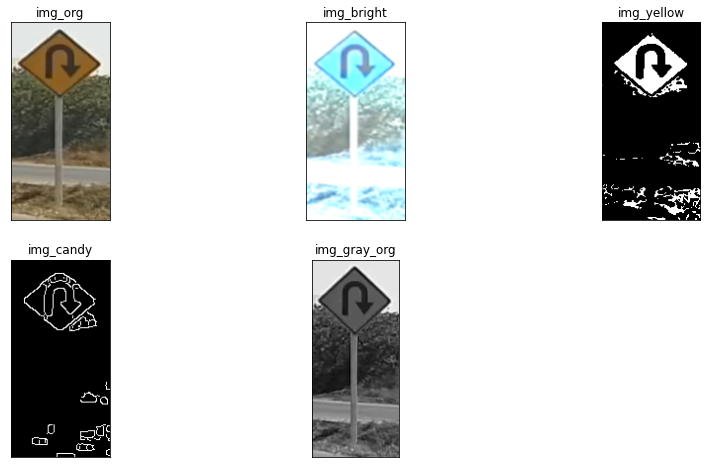

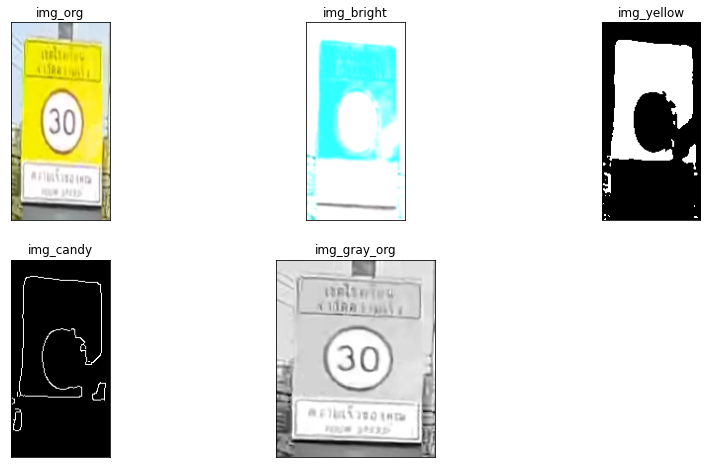

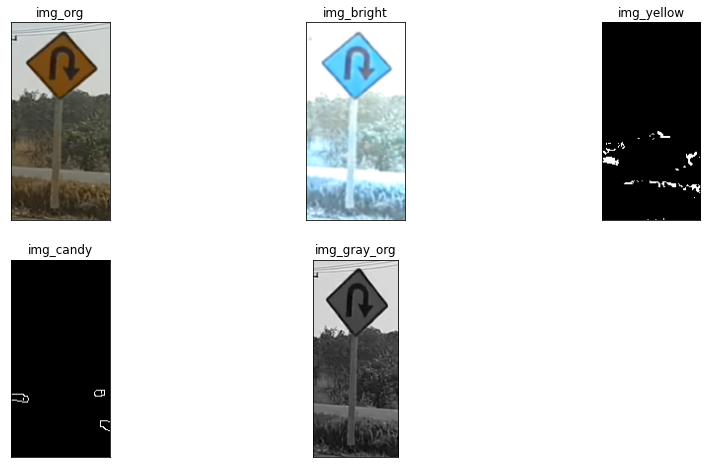

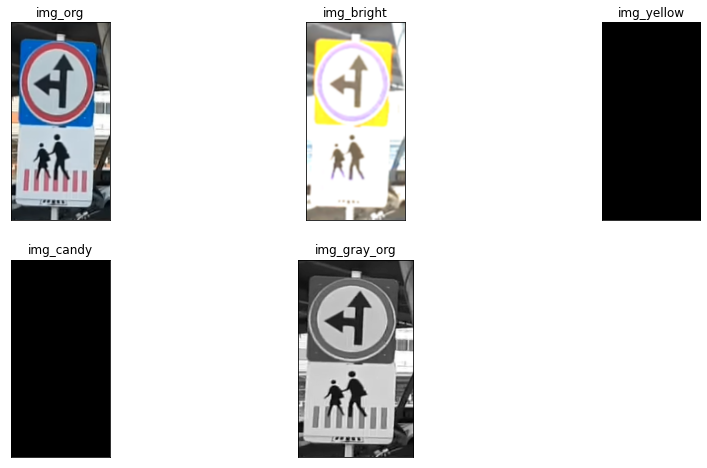

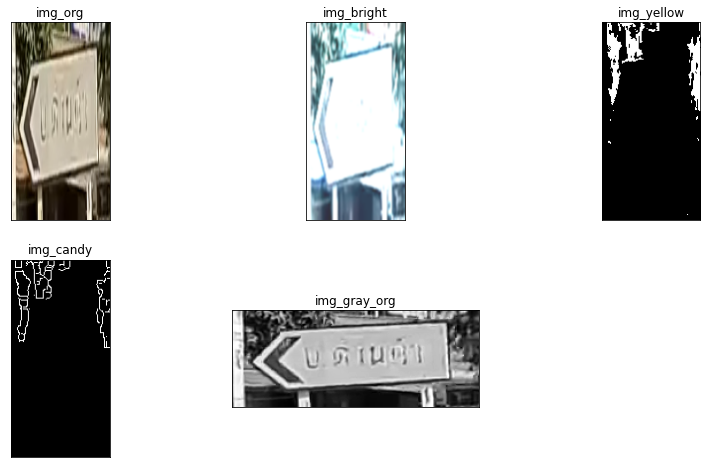

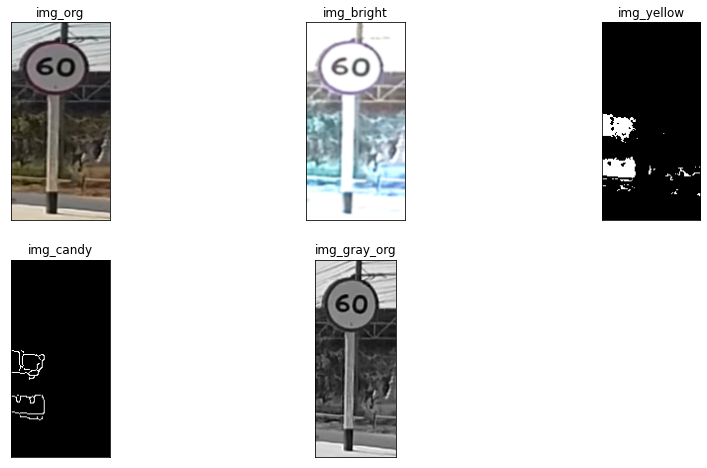

In [91]:
for item in test_files[:20]:
    try:
        get_mark(item)
    except:
        print(item)

In [ ]:
for item in test_files[:10]:
    try:
        detect_sign(item)
    except:
        print(item)